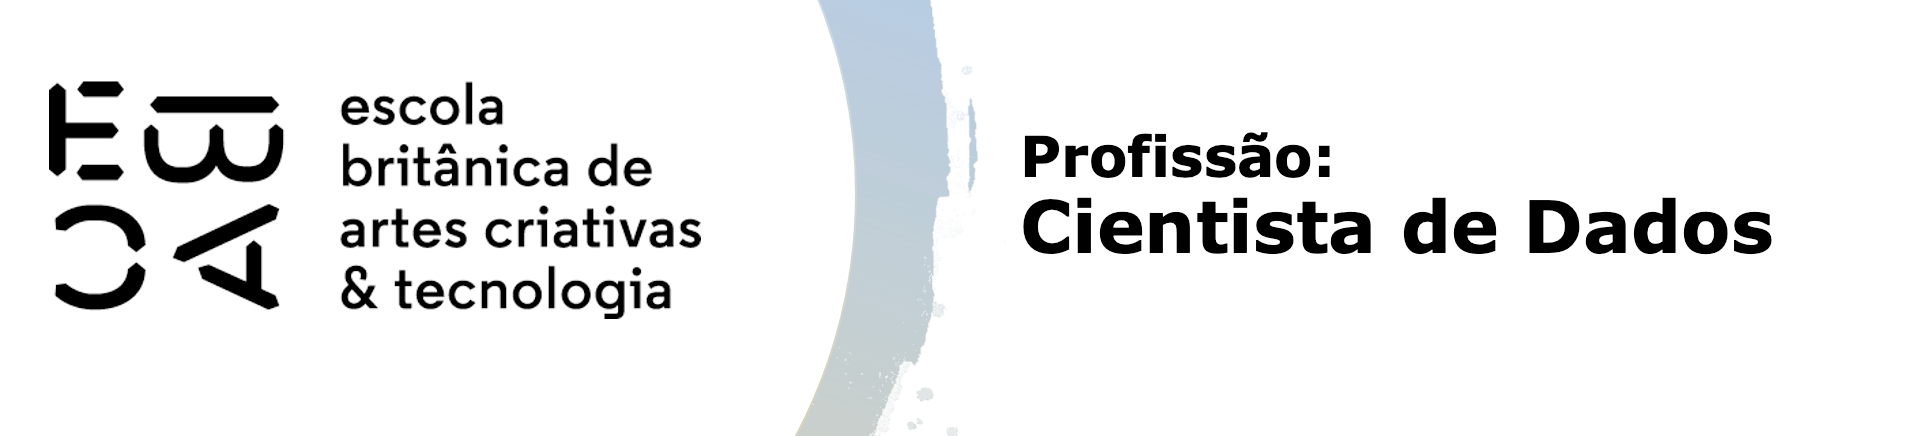

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [637]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from ydata_profiling import ProfileReport
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [639]:
df = pd.read_feather('./credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [642]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [644]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(0)

In [646]:
df['data_ref'] = pd.to_datetime(df['data_ref'])
data_max=df['data_ref'].max()
limite_3_meses = data_max - timedelta(days=90)
df_oot=df[df['data_ref'] >= limite_3_meses]
df_train=df[df['data_ref'] < limite_3_meses]
df_train.tail()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
599995 2015-12-01   2205    F                S               N           0   
599996 2015-12-01   1266    M                S               N           1   
599997 2015-12-01  13085    F                N               N           0   
599998 2015-12-01  10964    F                N               N           0   
599999 2015-12-01   5156    F                N               S           0   

         tipo_renda           educacao estado_civil tipo_residencia  idade  \
599995  Assalariado              Médio        União            Casa     47   
599996   Empresário  Superior completo       Casado            Casa     31   
599997  Pensionista              Médio       Casado            Casa     62   
599998  Assalariado  Superior completo       Casado            Casa     40   
599999  Pensionista              Médio     Solteiro            Casa     66   

        tempo_emprego  qt_pessoas_residencia     renda    mau  
599995      23.690411                    2.0  11009.92  False  
599996       3.756164                    3.0   4472.60  False  
599997       0.000000                    2.0   5117.17   True  
599998      12.939726                    2.0   2885.45   True  
599999       0.000000                    1.0   3395.65  False

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.


In [649]:
print(f"A base de treino tem {df_train.shape[0]} linhas\n")
print(f"A base de teste tem {df_oot.shape[0]} linhas\n")
df_train[['data_ref', 'index']].groupby('data_ref')\
                             .count()\
                             .reset_index()\
                             .rename(columns={'index': 'quantidade', 'data_ref': 'Data Referencia'})

A base de treino tem 600000 linhas

A base de teste tem 150000 linhas



Data Referencia  quantidade
0       2015-01-01       50000
1       2015-02-01       50000
2       2015-03-01       50000
3       2015-04-01       50000
4       2015-05-01       50000
5       2015-06-01       50000
6       2015-07-01       50000
7       2015-08-01       50000
8       2015-09-01       50000
9       2015-10-01       50000
10      2015-11-01       50000
11      2015-12-01       50000

- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [652]:
prof = ProfileReport(df_train.drop(columns=['data_ref', 'index']), explorative=True, minimal=False)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

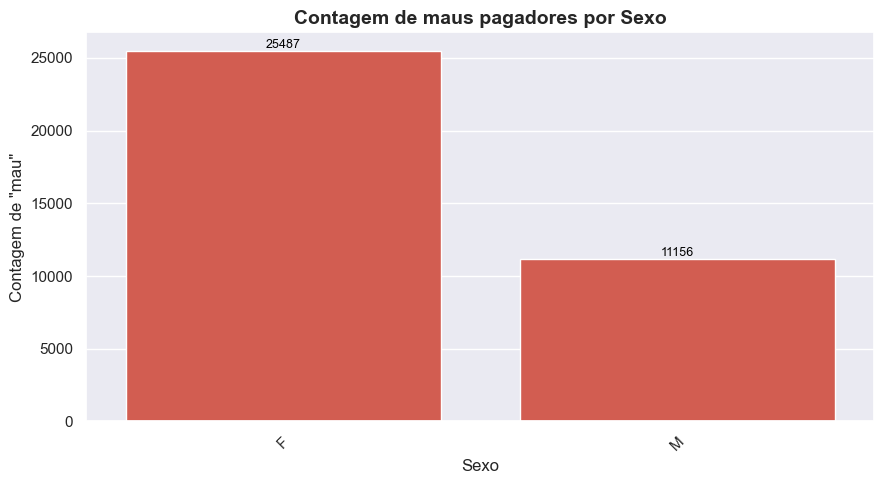

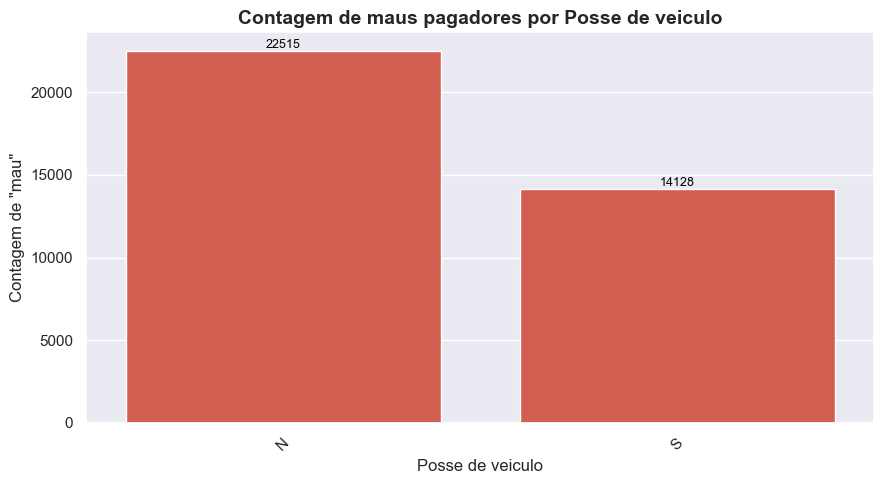

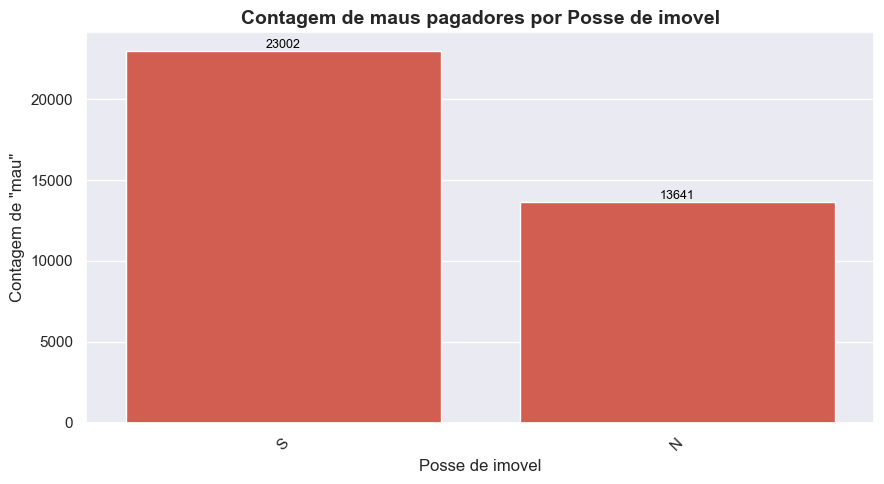

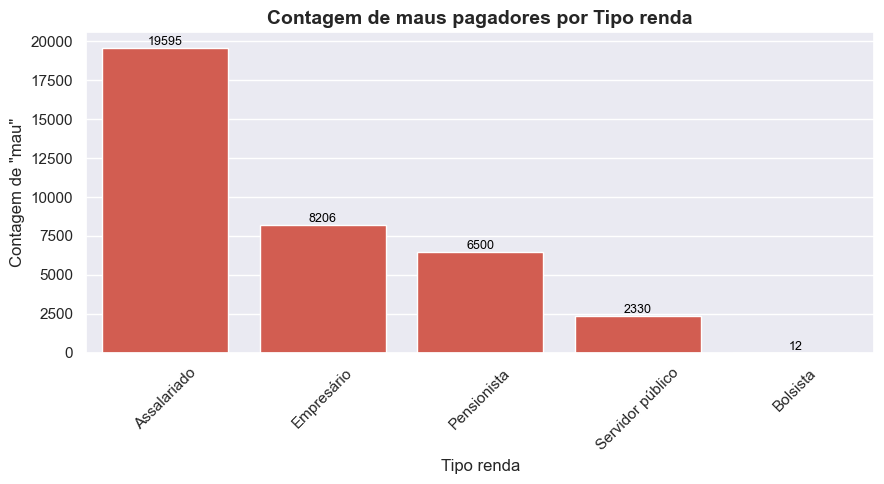

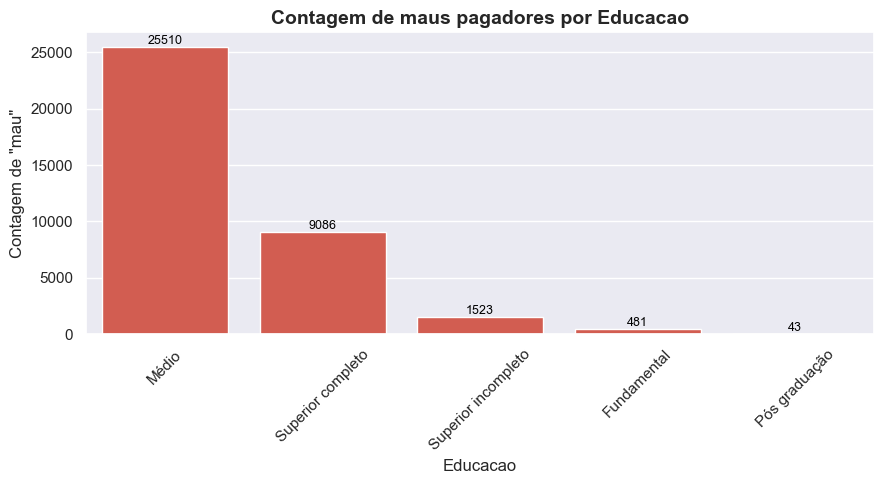

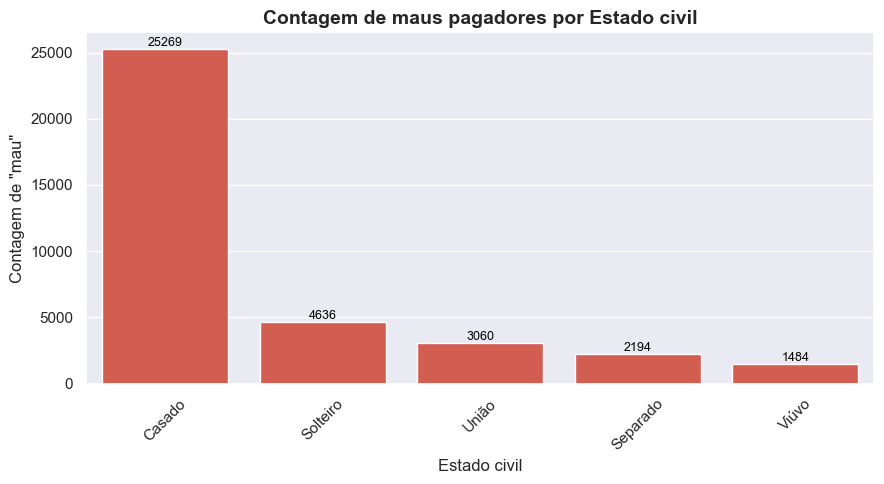

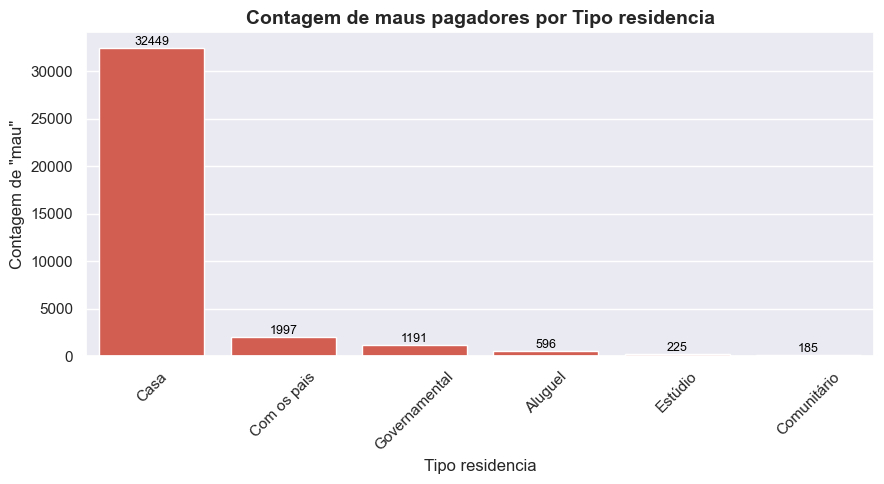

In [654]:
# Estilo visual
sns.set(style='darkgrid')

variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel','tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

for var in variaveis_categoricas:
    plt.figure(figsize=(9, 5))
    
    # Filtra só quem é "mau" (mau = 1)
    df_mau = df_train[df_train['mau'] == 1]
    
    # Conta quantos "maus" por categoria
    contagem_mau = df_mau[var].value_counts().reset_index()
    contagem_mau.columns = [var, 'contagem']
    contagem_mau = contagem_mau.sort_values(by='contagem', ascending=False)

    # Gráfico de barras
    ax = sns.barplot(data=contagem_mau, x=var, y='contagem', color='#E74C3C')

    # Adiciona os rótulos nas barras
    for i, row in contagem_mau.iterrows():
        ax.text(i, row['contagem'] + 1, f"{row['contagem']}", ha='center', va='bottom', fontsize=9, color='black')

    # Estética
    plt.title(f'Contagem de maus pagadores por {var.replace('_', ' ').capitalize()}', fontsize=14, weight='bold')
    plt.ylabel('Contagem de "mau"')
    plt.xlabel(var.replace('_', ' ').capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


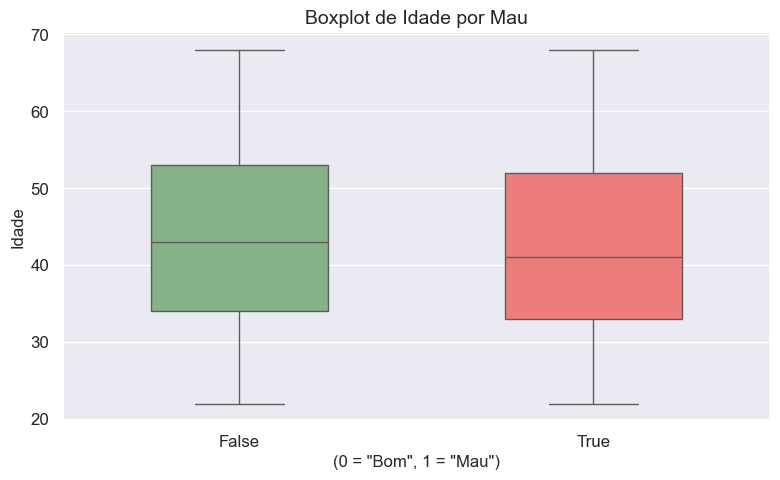

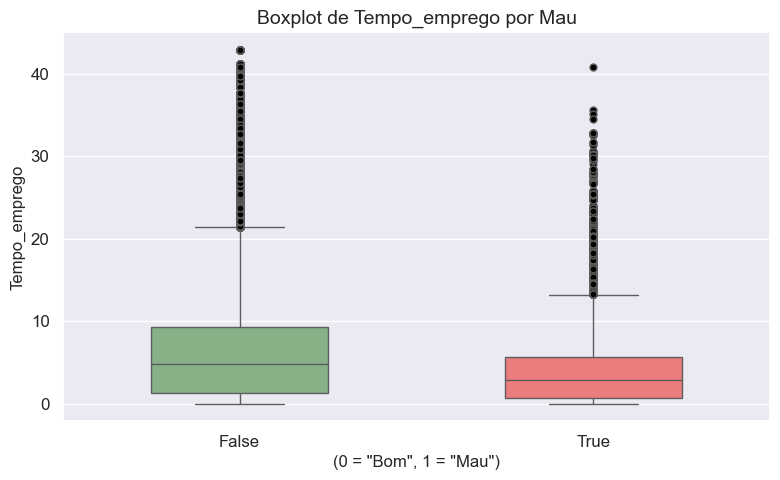

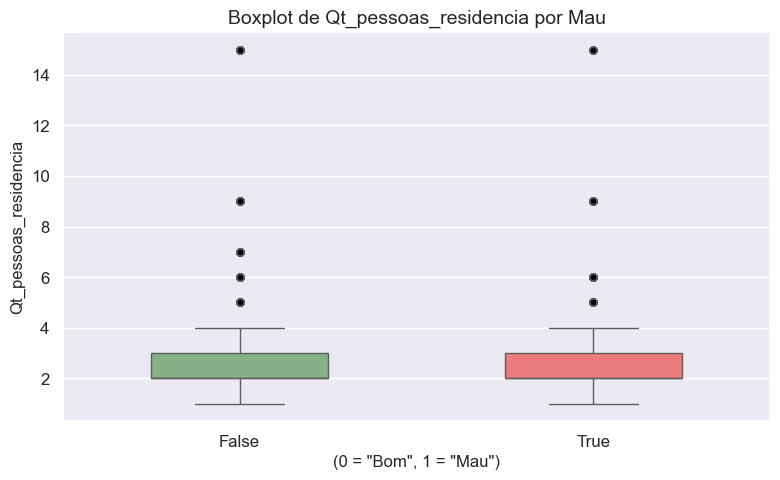

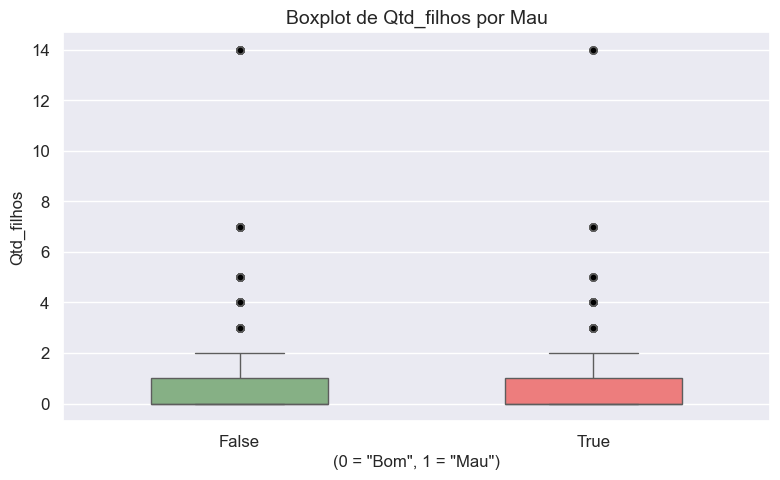

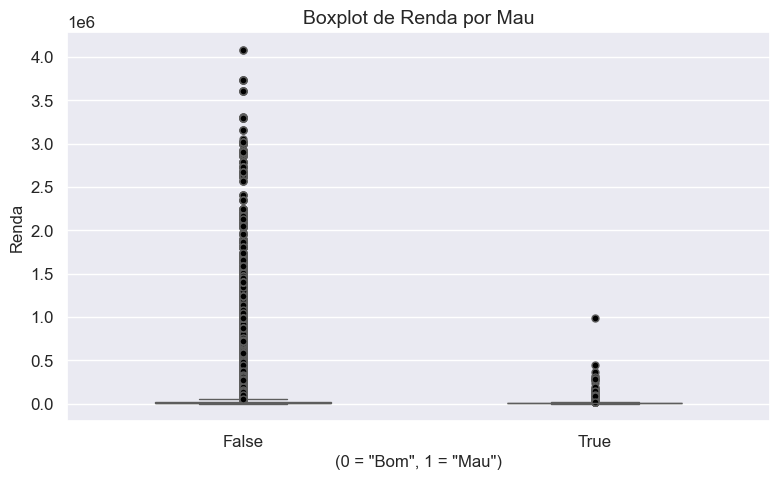

In [655]:
# Transformar a variável resposta em inteiro
df['mau'] = df_train.mau.astype('int64')

sns.set(style='darkgrid', palette='pastel', font_scale=1.1)

variaveis_numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']


for var in variaveis_numericas:
    plt.figure(figsize=(8, 5))

    ax = sns.boxplot(
        data=df_train,
        x='mau',
        y=var,
        hue='mau',
        palette={0: "#7FB77E", 1: "#FF6B6B"}, # 7FB77E verde, FF6B6B vermelho
        width=0.5,
        legend=False,
        flierprops=flierprops
    )

    ax.set_title(f'Boxplot de {var.capitalize()} por Mau', fontsize=14)
    ax.set_xlabel('(0 = "Bom", 1 = "Mau")', fontsize=12)
    ax.set_ylabel(var.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [657]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['data_ref','papel'] = 'data'
metadados.loc['index','papel'] = 'index'

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()
    
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
metadados

dtype  nmissing  valores_unicos       papel  \
data_ref               datetime64[ns]         0              12        data   
index                           int64         0           16650       index   
sexo                           object         0               2  covariavel   
posse_de_veiculo               object         0               2  covariavel   
posse_de_imovel                object         0               2  covariavel   
qtd_filhos                      int64         0               8  covariavel   
tipo_renda                     object         0               5  covariavel   
educacao                       object         0               5  covariavel   
estado_civil                   object         0               5  covariavel   
tipo_residencia                object         0               6  covariavel   
idade                           int64         0              47  covariavel   
tempo_emprego                 float64         0            3005  covariavel   
qt_pessoas_residencia         float64         0               9  covariavel   
renda                         float64         0          112472  covariavel   
mau                              bool         0               2    resposta   

                             IV  
data_ref                    NaN  
index                       NaN  
sexo                   0.002665  
posse_de_veiculo       0.000075  
posse_de_imovel        0.009690  
qtd_filhos             0.000055  
tipo_renda             0.009718  
educacao               0.003690  
estado_civil           0.001305  
tipo_residencia        0.003330  
idade                  0.018434  
tempo_emprego          0.270820  
qt_pessoas_residencia  0.001263  
renda                  0.959826  
mau                         NaN

In [658]:
def biv_discreta(var, df_train):
    df_train['bom'] = 1 - df_train['mau']
    g = df_train.groupby(var)

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont': g[var].count()
    })

    biv['ep'] = (biv['mau'] * (1 - biv['mau']) / biv['cont']) ** 0.5
    biv['mau_sup'] = biv['mau'] + t.ppf([0.975], biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] + t.ppf([0.025], biv['cont'] - 1) * biv['ep']

    biv['logit'] = np.log(biv['mau'] / (1 - biv['mau']))
    biv['logit_sup'] = np.log(biv['mau_sup'] / (1 - biv['mau_sup']))
    biv['logit_inf'] = np.log(biv['mau_inf'] / (1 - biv['mau_inf']))

    woe_geral = np.log(df_train['mau'].mean() / (1 - df_train['mau'].mean()))
    biv['woe'] = biv['logit'] - woe_geral
    biv['woe_sup'] = biv['logit_sup'] - woe_geral
    biv['woe_inf'] = biv['logit_inf'] - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    # gráfico de Weight of Evidence vs var
    ax[0].plot(biv[var], biv['woe'], ':bo', label='woe')
    ax[0].plot(biv[var], biv['woe_sup'], 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv['woe_inf'], 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-0.3, num_cat - 0.7])
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    # gráfico de barras
    ax[1].bar(range(num_cat), biv['cont'], tick_label=biv[var])
    ax[1].set_xticks(range(num_cat))
    ax[1].set_xticklabels(biv[var], rotation=15)
    ax[1].set_ylabel("Contagem")
    ax[1].set_xlabel(var.replace('_', ' ').capitalize())

    plt.tight_layout()
    return biv

In [659]:
def biv_continua(var, ncat, df_train):
    df_train['bom'] = 1-df_train.mau
    cat_srs, bins = pd.qcut(df_train[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df_train.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df_train.mau.mean()
    woe_geral = np.log(df_train.mau.mean() / (1 - df_train.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    # gráfico de barras
    ax[1].bar(range(num_cat), biv['cont'], tick_label=biv[var])
    ax[1].set_xticks(range(num_cat))
    ax[1].set_xticklabels(biv.index.astype(str), rotation=15)
    ax[1].set_ylabel("Contagem")
    ax[1].set_xlabel(var.replace('_', ' ').capitalize())
    
    return None

qt_bom  qt_mau       mau quantidade_de_filhos    cont  \
quantidade_de_filhos                                                          
Sem filhos            389129   24753  0.059807           Sem filhos  413882   
Até 2 filhos          166729   11345  0.063709         Até 2 filhos  178074   
Mais que 2 filhos       7499     545  0.067752    Mais que 2 filhos    8044   

                            ep   mau_sup   mau_inf     logit  logit_sup  \
quantidade_de_filhos                                                      
Sem filhos            0.000369  0.060529  0.059084 -2.754964  -2.742189   
Até 2 filhos          0.000579  0.064844  0.062575 -2.687593  -2.668731   
Mais que 2 filhos     0.002802  0.073245  0.062259 -2.621739  -2.537875   

                      logit_inf       woe   woe_sup   woe_inf  
quantidade_de_filhos                                           
Sem filhos            -2.767885 -0.022273 -0.009497 -0.035194  
Até 2 filhos          -2.706769  0.045098  0.063960  0.025922  
Mais que 2 filhos     -2.712164  0.110952  0.194816  0.020528

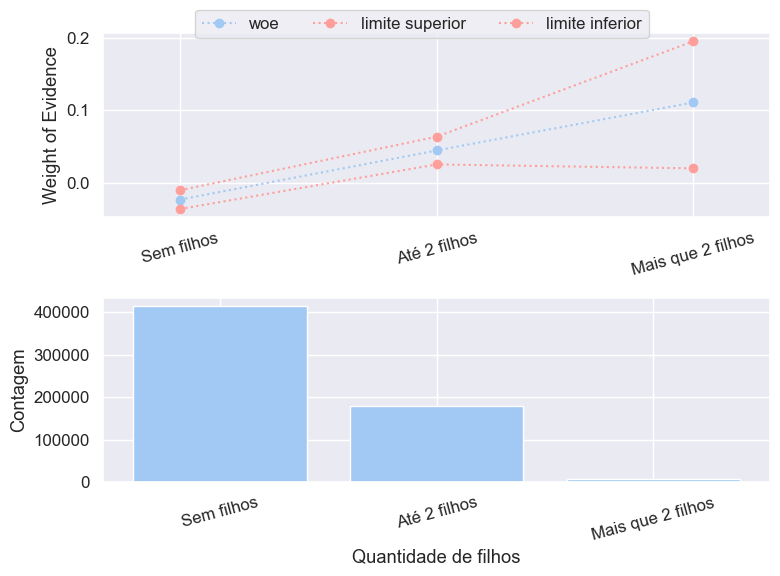

In [660]:
df_train['quantidade_de_filhos'] = pd.cut(df_train['qtd_filhos'], bins=[-1, 0, 2, 15], labels=['Sem filhos', 'Até 2 filhos', 'Mais que 2 filhos'])
biv_discreta('quantidade_de_filhos', df_train)

qt_bom  qt_mau       mau         tipo_renda    cont  \
tipo_renda                                                               
Assalariado        288865   19595  0.063525        Assalariado  308460   
Bolsista/Servidor   49930    2342  0.044804  Bolsista/Servidor   52272   
Empresário         129935    8206  0.059403         Empresário  138141   
Pensionista         94627    6500  0.064276        Pensionista  101127   

                         ep   mau_sup   mau_inf     logit  logit_sup  \
tipo_renda                                                             
Assalariado        0.000439  0.064386  0.062665 -2.690685  -2.676307   
Bolsista/Servidor  0.000905  0.046578  0.043031 -3.059617  -3.018938   
Empresário         0.000636  0.060650  0.058157 -2.762169  -2.740076   
Pensionista        0.000771  0.065787  0.062764 -2.678141  -2.653280   

                   logit_inf       woe   woe_sup   woe_inf  
tipo_renda                                                  
Assalariado        -2.705246  0.042006  0.056384  0.027445  
Bolsista/Servidor  -3.101860 -0.326926 -0.286247 -0.369169  
Empresário         -2.784700 -0.029478 -0.007385 -0.052009  
Pensionista        -2.703552  0.054550  0.079411  0.029139

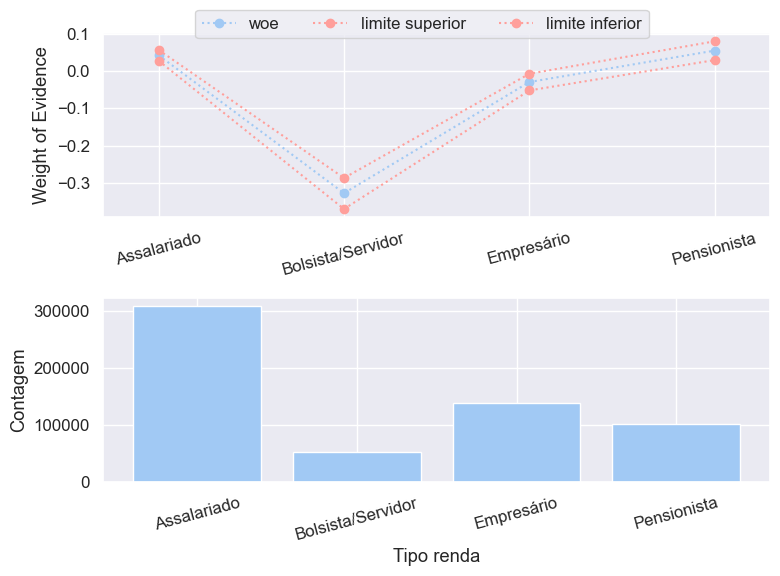

In [661]:
#juntar bolsista com Servidor público
df_train.tipo_renda.replace({'Bolsista':'Bolsista/Servidor', 'Servidor público': 'Bolsista/Servidor'}, inplace=True)
biv_discreta('tipo_renda', df_train)

qt_bom  qt_mau       mau           educacao    cont  \
educacao                                                                 
Fundamental/Médio  386359   25991  0.063031  Fundamental/Médio  412350   
Superior           176998   10652  0.056765           Superior  187650   

                         ep   mau_sup   mau_inf     logit  logit_sup  \
educacao                                                               
Fundamental/Médio  0.000378  0.063773  0.062290 -2.699017  -2.686525   
Superior           0.000534  0.057812  0.055718 -2.810391  -2.791005   

                   logit_inf       woe   woe_sup   woe_inf  
educacao                                                    
Fundamental/Médio  -2.711646  0.033674  0.046166  0.021045  
Superior           -2.830116 -0.077700 -0.058314 -0.097425

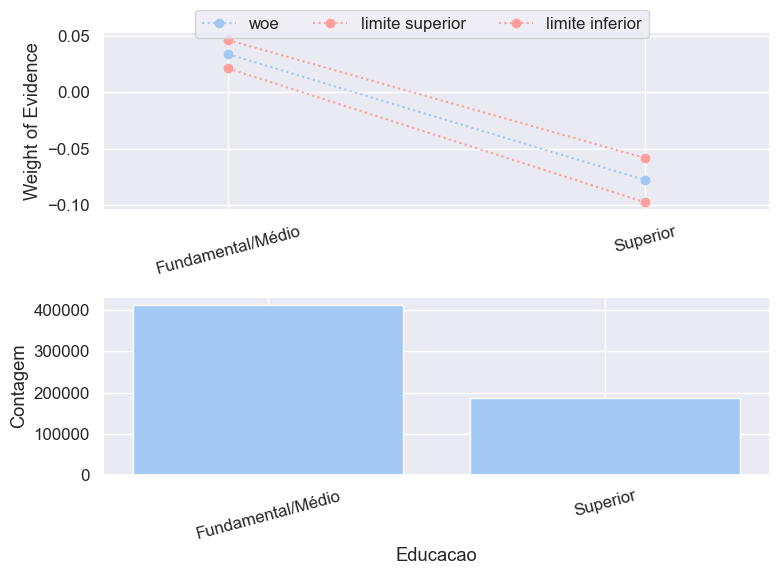

In [662]:
#juntar fundamental e médio 
#juntar Superior completo e incompleto com Pós graduação 
df_train.educacao.replace({
    'Médio':'Fundamental/Médio',
    'Fundamental': 'Fundamental/Médio',
    'Pós graduação': 'Superior',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior'
}, inplace=True)
biv_discreta('educacao', df_train)

qt_bom  qt_mau       mau             estado_civil  \
estado_civil                                                                 
Casado/União             438928   28329  0.060628             Casado/União   
Solteiro/Separado/Viúvo  124429    8314  0.062632  Solteiro/Separado/Viúvo   

                           cont        ep   mau_sup   mau_inf     logit  \
estado_civil                                                              
Casado/União             467257  0.000349  0.061313  0.059944 -2.740449   
Solteiro/Separado/Viúvo  132743  0.000665  0.063936  0.061329 -2.705794   

                         logit_sup  logit_inf       woe   woe_sup   woe_inf  
estado_civil                                                                 
Casado/União             -2.728498  -2.752528 -0.007758  0.004194 -0.019837  
Solteiro/Separado/Viúvo  -2.683805  -2.728215  0.026897  0.048886  0.004476

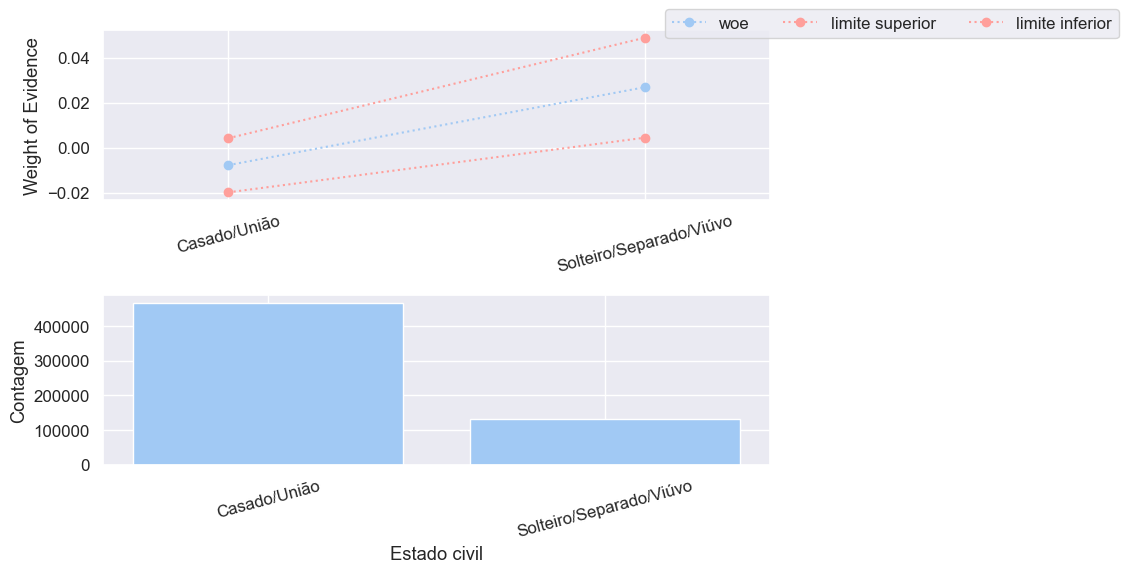

In [663]:
#juntar Casado e União
# juntar Solteiro,Separado e Viúvo 
df_train.estado_civil.replace({
    'Casado':'Casado/União',
    'União': 'Casado/União',
    'Solteiro': 'Solteiro/Separado/Viúvo',
    'Separado': 'Solteiro/Separado/Viúvo',
    'Viúvo': 'Solteiro/Separado/Viúvo'
}, inplace=True)
biv_discreta('estado_civil', df_train)


qt_bom  qt_mau       mau tipo_residencia    cont        ep  \
tipo_residencia                                                               
Casa             506887   32449  0.060165            Casa  539336  0.000324   
Outros            56470    4194  0.069135          Outros   60664  0.001030   

                  mau_sup   mau_inf     logit  logit_sup  logit_inf       woe  \
tipo_residencia                                                                 
Casa             0.060799  0.059530 -2.748618  -2.737450  -2.759898 -0.015927   
Outros           0.071154  0.067116 -2.600055  -2.569102  -2.631856  0.132637   

                  woe_sup   woe_inf  
tipo_residencia                      
Casa            -0.004759 -0.027207  
Outros           0.163590  0.100835

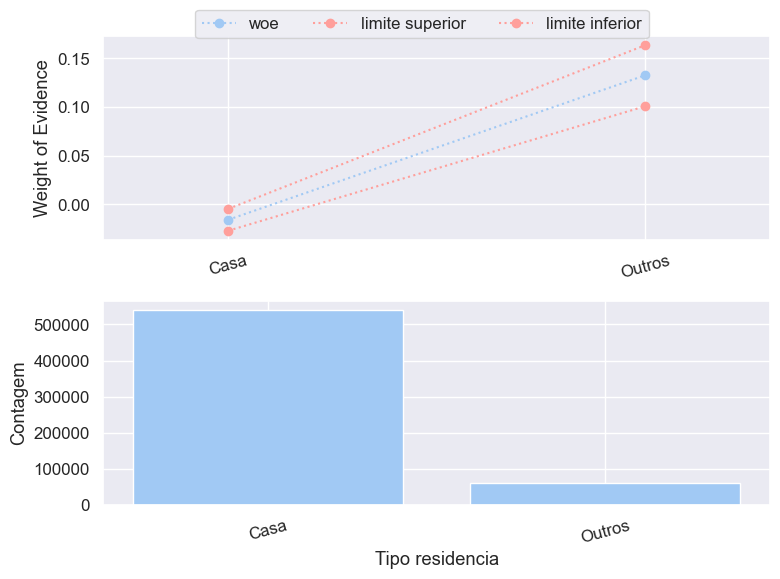

In [664]:
df_train.tipo_residencia.replace({
    'Com os pais':'Outros',
    'Governamental': 'Outros',
    'Aluguel': 'Outros',
    'Estúdio': 'Outros',
    'Comunitário': 'Outros'
}, inplace=True)
biv_discreta('tipo_residencia', df_train)

In [665]:
df_train['tipo_residencia'].value_counts()

tipo_residencia
Casa      539336
Outros     60664
Name: count, dtype: int64

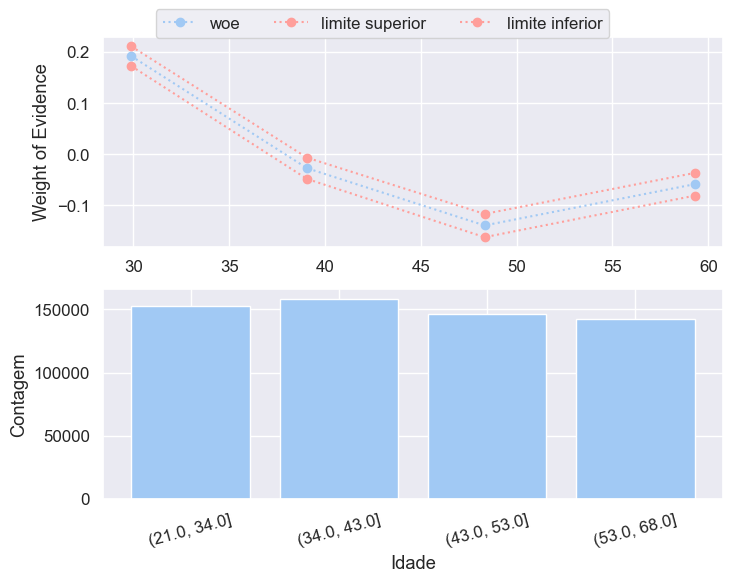

In [666]:
biv_continua('idade',4, df_train)

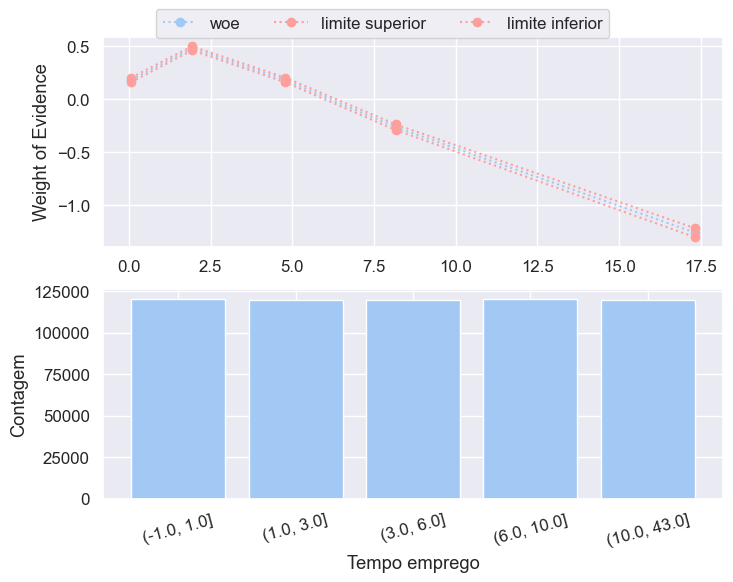

In [667]:
biv_continua('tempo_emprego',5, df_train)

qt_bom  qt_mau       mau  \
quantidade_de_pessoas_residencia                             
Até 2 pessoas                     408788   26050  0.059907   
Mais que 2 pessoas                154569   10593  0.064137   

                                 quantidade_de_pessoas_residencia    cont  \
quantidade_de_pessoas_residencia                                            
Até 2 pessoas                                       Até 2 pessoas  434838   
Mais que 2 pessoas                             Mais que 2 pessoas  165162   

                                        ep   mau_sup   mau_inf     logit  \
quantidade_de_pessoas_residencia                                           
Até 2 pessoas                     0.000360  0.060613  0.059202 -2.753179   
Mais que 2 pessoas                0.000603  0.065319  0.062955 -2.680447   

                                  logit_sup  logit_inf       woe   woe_sup  \
quantidade_de_pessoas_residencia                                             
Até 2 pessoas                     -2.740723  -2.765773 -0.020488 -0.008032   
Mais que 2 pessoas                -2.660929  -2.700303  0.052244  0.071762   

                                   woe_inf  
quantidade_de_pessoas_residencia            
Até 2 pessoas                    -0.033082  
Mais que 2 pessoas                0.032388

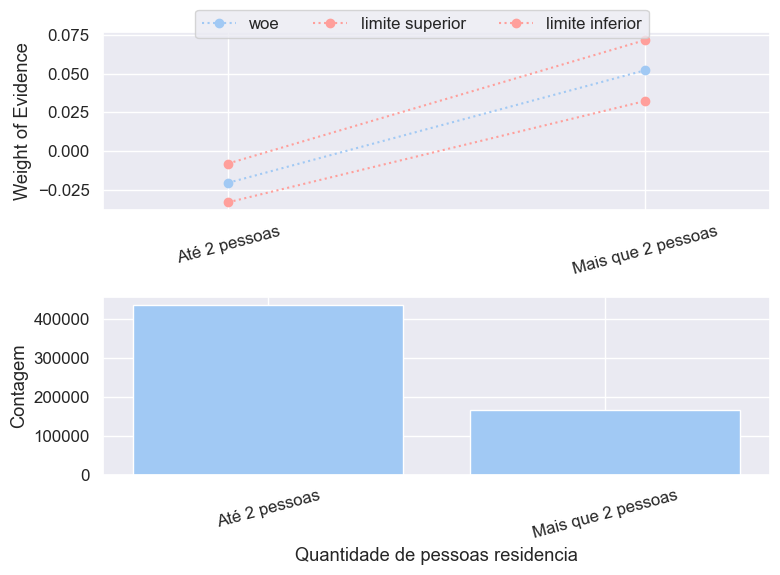

In [668]:
df_train['quantidade_de_pessoas_residencia'] = pd.cut(df_train['qt_pessoas_residencia'], bins=[-1, 2, 15], labels=['Até 2 pessoas', 'Mais que 2 pessoas'])
biv_discreta('quantidade_de_pessoas_residencia', df_train)

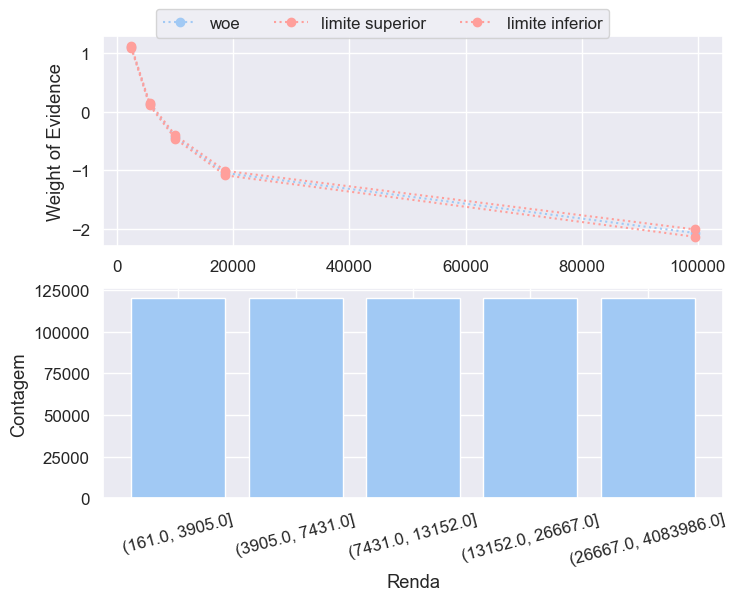

In [669]:
biv_continua('renda',5, df_train)

In [670]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel  + tipo_renda + educacao + estado_civil 
    + tipo_residencia + idade + tempo_emprego  + renda + qtd_filhos  + qt_pessoas_residencia'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599985
Model Family:                         Binomial   Df Model:                           14
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2484e+05
Date:                         Thu, 17 Apr 2025   Deviance:                   2.4967e+05
Time:                                 15:58:43   Pearson chi2:                 1.62e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04275
Covariance Type:                     nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.2323      0.181      6.793      0.000       0.877       1.588
sexo[T.M]                                   0.1252      0.013      9.576      0.000       0.100       0.151
posse_de_veiculo[T.S]                      -0.0296      0.012     -2.397      0.017      -0.054      -0.005
posse_de_imovel[T.S]                        0.0858      0.012      7.285      0.000       0.063       0.109
tipo_renda[T.Bolsista/Servidor]             0.0334      0.023      1.443      0.149      -0.012       0.079
tipo_renda[T.Empresário]                    0.0515      0.014      3.685      0.000       0.024       0.079
tipo_renda[T.Pensionista]                   0.2237      0.022     10.191      0.000       0.181       0.267
educacao[T.Superior]                        0.0591      0.013      4.694      0.000       0.034       0.084
estado_civil[T.Solteiro/Separado/Viúvo]     0.1212      0.090      1.347      0.178      -0.055       0.298
tipo_residencia[T.Outros]                  -0.0211      0.018     -1.180      0.238      -0.056       0.014
idade                                       0.0001      0.001      0.167      0.867      -0.001       0.001
tempo_emprego                               0.0236      0.002     13.118      0.000       0.020       0.027
renda                                       0.0001   1.09e-06     93.687      0.000    9.96e-05       0.000
qtd_filhos                                 -0.1272      0.089     -1.422      0.155      -0.303       0.048
qt_pessoas_residencia                       0.1247      0.089      1.396      0.163      -0.050       0.300
===========================================================================================================
"""

In [671]:
metadados.sort_values(by='IV', ascending=False)


dtype  nmissing  valores_unicos       papel  \
renda                         float64         0          112472  covariavel   
tempo_emprego                 float64         0            3005  covariavel   
idade                           int64         0              47  covariavel   
tipo_renda                     object         0               5  covariavel   
posse_de_imovel                object         0               2  covariavel   
educacao                       object         0               5  covariavel   
tipo_residencia                object         0               6  covariavel   
sexo                           object         0               2  covariavel   
estado_civil                   object         0               5  covariavel   
qt_pessoas_residencia         float64         0               9  covariavel   
posse_de_veiculo               object         0               2  covariavel   
qtd_filhos                      int64         0               8  covariavel   
data_ref               datetime64[ns]         0              12        data   
index                           int64         0           16650       index   
mau                              bool         0               2    resposta   

                             IV  
renda                  0.959826  
tempo_emprego          0.270820  
idade                  0.018434  
tipo_renda             0.009718  
posse_de_imovel        0.009690  
educacao               0.003690  
tipo_residencia        0.003330  
sexo                   0.002665  
estado_civil           0.001305  
qt_pessoas_residencia  0.001263  
posse_de_veiculo       0.000075  
qtd_filhos             0.000055  
data_ref                    NaN  
index                       NaN  
mau                         NaN

In [672]:
#removido qtd_filhos e posse_de_veiculo, pelo baixo valor de IV
#removido estado_civil pelo alto P de 0.935 na nova regressão feita com qtd_filhos e posse_de_veiculo removido
formula = '''
    mau ~ sexo  + posse_de_imovel  + tipo_renda + educacao 
    + tipo_residencia + idade + tempo_emprego  + renda  + qt_pessoas_residencia'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599988
Model Family:                         Binomial   Df Model:                           11
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2484e+05
Date:                         Thu, 17 Apr 2025   Deviance:                   2.4968e+05
Time:                                 15:58:58   Pearson chi2:                 1.61e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04274
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.4746      0.036     40.866      0.000       1.404       1.545
sexo[T.M]                           0.1147      0.012      9.321      0.000       0.091       0.139
posse_de_imovel[T.S]                0.0853      0.012      7.245      0.000       0.062       0.108
tipo_renda[T.Bolsista/Servidor]     0.0351      0.023      1.515      0.130      -0.010       0.080
tipo_renda[T.Empresário]            0.0511      0.014      3.658      0.000       0.024       0.078
tipo_renda[T.Pensionista]           0.2252      0.022     10.265      0.000       0.182       0.268
educacao[T.Superior]                0.0561      0.013      4.481      0.000       0.032       0.081
tipo_residencia[T.Outros]          -0.0207      0.018     -1.159      0.247      -0.056       0.014
idade                               0.0002      0.001      0.263      0.793      -0.001       0.002
tempo_emprego                       0.0235      0.002     13.078      0.000       0.020       0.027
renda                               0.0001   1.09e-06     93.698      0.000    9.96e-05       0.000
qt_pessoas_residencia              -0.0021      0.006     -0.330      0.741      -0.015       0.010
===================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [674]:
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 6.1% 
AUC: 23.4% 
GINI: -53.1%
KS: 39.4%


In [675]:
df_oot.tipo_renda.replace({'Bolsista':'Bolsista/Servidor', 'Servidor público': 'Bolsista/Servidor'}, inplace=True)
df_oot.educacao.replace({
    'Médio':'Fundamental/Médio',
    'Fundamental': 'Fundamental/Médio',
    'Pós graduação': 'Superior',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior'
}, inplace=True)
df_oot.tipo_residencia.replace({
    'Com os pais':'Outros',
    'Governamental': 'Outros',
    'Aluguel': 'Outros',
    'Estúdio': 'Outros',
    'Comunitário': 'Outros'
}, inplace=True)
df_oot['quantidade_de_pessoas_residencia'] = pd.cut(df_oot['qt_pessoas_residencia'], bins=[-1, 2, 15], labels=['Até 2 pessoas', 'Mais que 2 pessoas'])

df_oot['score'] = rl.predict(df_oot)

# Acurácia
acc = metrics.accuracy_score(df_oot.mau, df_oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_oot.mau, df_oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_oot.loc[df_oot.mau == 1, 'score'], df_oot.loc[df_oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.7% 
AUC: 27.6% 
GINI: -44.7%
KS: 32.7%
